# Generating new cartoon images

Following this [DataCamp tutorial](https://www.datacamp.com/community/tutorials/generative-adversarial-networks)

## Import packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


## Set some variables

In [2]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

## Create the generator and discriminator networks

In [5]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

## Combine the generator and discriminator into a GAN

In [6]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

## Save training progress updates

In [7]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

# Train the network

In [6]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [ ]:
"""MNIST handwritten digits dataset.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from ..utils.data_utils import get_file
import numpy as np


def load_data(path='mnist.npz'):
    """Loads the MNIST dataset.

    # Arguments
        path: path where to cache the dataset locally
            (relative to ~/.keras/datasets).

    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    path = get_file(path,
                    origin='https://s3.amazonaws.com/img-datasets/mnist.npz',
                    file_hash='8a61469f7ea1b51cbae51d4f78837e45')
    f = np.load(path)
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)

In [7]:
from scipy import ndimage

In [8]:
import pandas as pd

In [9]:
df = pd.read_json("./cartoons.json")
df.drop_duplicates(inplace=True)
df.set_index("id", inplace=True)
print(df.shape)
df.head(3)

(1493, 6)


,caption,caption_raw,cartoon_bank_url,date,pn,src
id,,,,,,
2831481,“Please compliment Stewart on the firewood. He...,&ldquo;Please compliment Stewart on the firewo...,,2014-09-16 14:20:00,aa39,https://www.newyorker.com/wp-content/uploads/1...
1550951,“Russ is the sort of person who never wants to...,&ldquo;Russ is the sort of person who never wa...,,2014-07-14 00:10:00,a18048,https://www.newyorker.com/wp-content/uploads/2...
2922743,,,http://www.condenaststore.com/-sp/_i13010768_.htm,2014-12-05 14:36:00,a18714,https://www.newyorker.com/wp-content/uploads/2...


In [10]:
def displayCartoon(cartoon, figsize=(8, 8)):
    """Displays an image with caption from a row of the DataFrame"""
    fn = f"./images/{cartoon.name}.{cartoon.src.split('.')[-1]}"
    image = plt.imread(fn)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image, cmap="gray")
    ax.set(**{"xticks": [], "yticks": []})
    ax.set_xlabel("\n" + cartoon.caption, fontsize=16)
    plt.show()

In [125]:
t0 = time.time()
images = []
for index, cartoon in df.sample(100).iterrows():
    fn = f"./images/{cartoon.name}.{cartoon.src.split('.')[-1]}"
    im = plt.imread(fn)    
    if len(im.shape) == 3:
        im = im[:, :, 0]
    im = im.
    images.append(im)
elapsed = time.time() - t0
print(elapsed)

6.226027011871338


In [136]:
shapes = np.array([im.shape for im in images])

In [141]:
shapes.mean(axis=0)

array([576.29, 696.3 ])

In [157]:
np.median(shapes[:, 0])

470.0

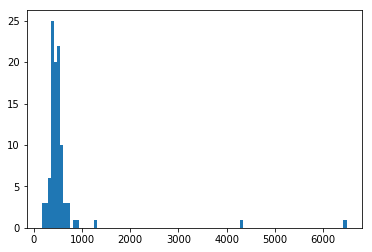

In [153]:
plt.hist(shapes[:, 0], 100)
plt.show()

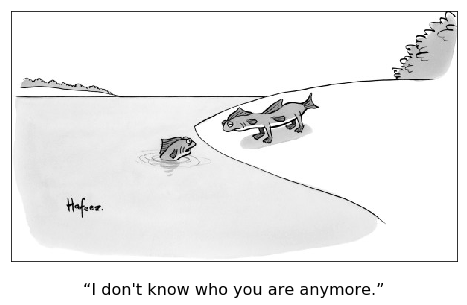

In [14]:
displayCartoon(df.sample(1).iloc[0])

In [ ]:
import cv2
image = cv2.imread(fn)
im = cv2.resize(image, (128, 400))

In [227]:
def load_cartoon_data(path):
    """Loads cartoon images as training and testing data"""
    size = (600, 470)
    im = cv2.imread(fn)
    im = cv2.resize(im, size)
    if len(im.shape) == 3:
        im = im[:, :, 0]
    return im

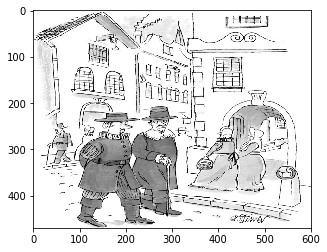

In [232]:
im = load_cartoon_data("")
plt.imshow(im, cmap="gray")

In [11]:
X_train, y_train, X_test, y_test = load_minst_data()

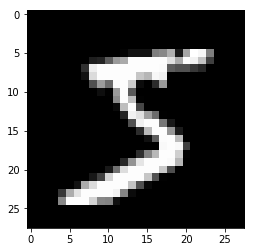

In [39]:
plt.imshow(X_train[0, :].reshape(2 * (int(np.sqrt(X_train.shape[1])), )), cmap='gray')

In [7]:
def train(epochs=1, batch_size=128):
    t0 = time.time()
    t1 = time.time()
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        print(f"Time since last epoch: {(time.time() - t1) / 60:.2f} minutes.")
        t1 = time.time()
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 5 == 0 or e == epochs:
            plot_generated_images(e, generator)
    print(f"\nDone. Total time: {(time.time() - t0) / 60:.2f} minutes.")

11493376/11490434 [==============================] - 1s 0us/step


  0%|          | 0/937 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
Time since last epoch: 0.05 minutes.


  0%|          | 1/937 [00:00<03:00,  5.17it/s]

--------------- Epoch 2 ---------------
Time since last epoch: 3.19 minutes.


  0%|          | 0/937 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------
Time since last epoch: 2.97 minutes.


100%|██████████| 937/937 [02:54<00:00,  5.36it/s]



Done. Total time: 9.20 minutes.


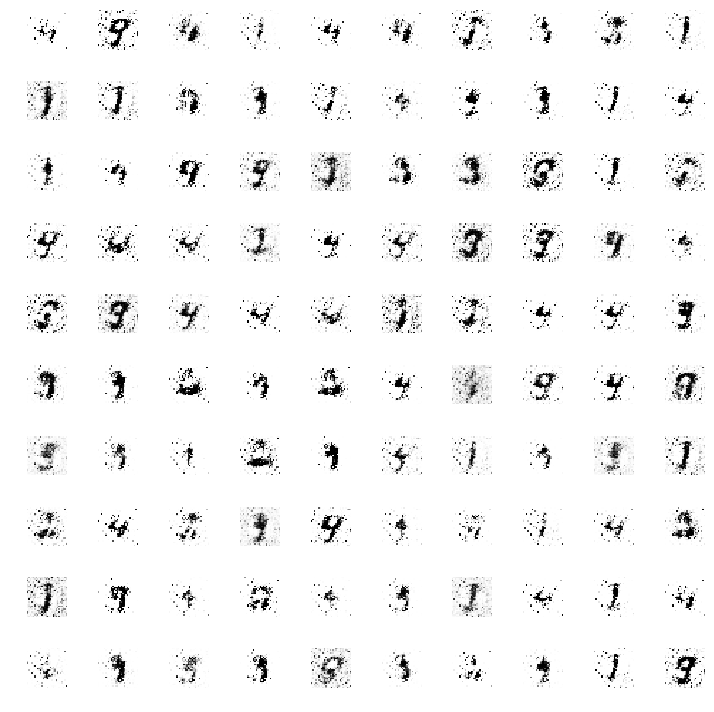

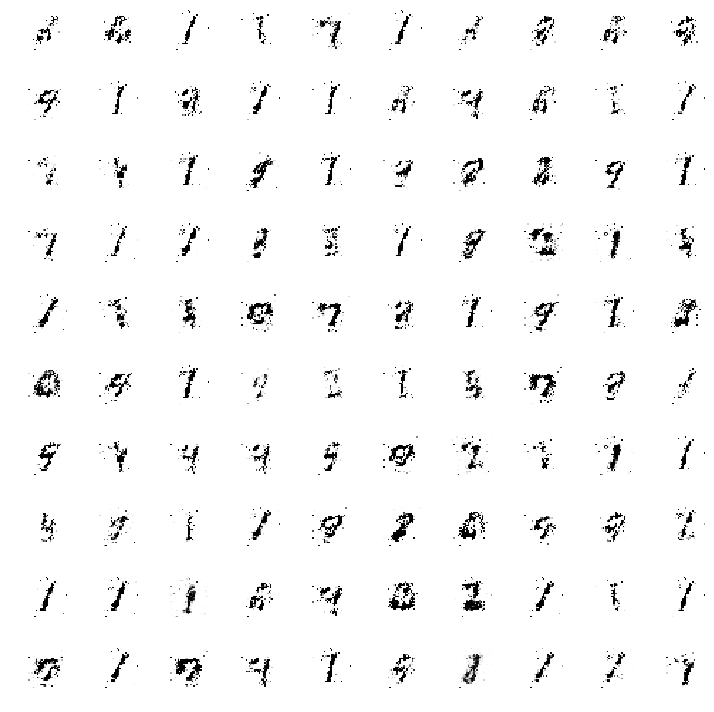

In [10]:
# Train the network
train(3, 64)

  0%|          | 0/937 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
Time since last epoch: 0.012486930688222249 minutes.


  0%|          | 2/937 [00:00<00:58, 16.11it/s]

--------------- Epoch 2 ---------------
Time since last epoch: 1.0428708831469218 minutes.


  0%|          | 2/937 [00:00<00:59, 15.71it/s]

--------------- Epoch 3 ---------------
Time since last epoch: 0.9450689196586609 minutes.


  0%|          | 2/937 [00:00<00:57, 16.25it/s]

--------------- Epoch 4 ---------------
Time since last epoch: 0.9551202813784282 minutes.


  0%|          | 2/937 [00:00<00:58, 16.09it/s]

--------------- Epoch 5 ---------------
Time since last epoch: 0.9453921715418497 minutes.


  0%|          | 2/937 [00:00<00:57, 16.20it/s]

--------------- Epoch 6 ---------------
Time since last epoch: 0.9896186669667562 minutes.


  0%|          | 2/937 [00:00<01:01, 15.30it/s]

--------------- Epoch 7 ---------------
Time since last epoch: 0.9477767864863078 minutes.


  0%|          | 2/937 [00:00<00:58, 16.03it/s]

--------------- Epoch 8 ---------------
Time since last epoch: 0.9594054023424784 minutes.


  0%|          | 2/937 [00:00<00:57, 16.21it/s]

--------------- Epoch 9 ---------------
Time since last epoch: 0.9452948013941447 minutes.


  0%|          | 2/937 [00:00<01:01, 15.12it/s]

--------------- Epoch 10 ---------------
Time since last epoch: 0.9449731667836507 minutes.


  0%|          | 2/937 [00:00<01:04, 14.56it/s]

--------------- Epoch 11 ---------------
Time since last epoch: 0.985880184173584 minutes.


  0%|          | 2/937 [00:00<00:57, 16.18it/s]

--------------- Epoch 12 ---------------
Time since last epoch: 0.9632444858551026 minutes.


  0%|          | 2/937 [00:00<00:59, 15.80it/s]

--------------- Epoch 13 ---------------
Time since last epoch: 0.9647112329800923 minutes.


  0%|          | 2/937 [00:00<00:58, 16.05it/s]

--------------- Epoch 14 ---------------
Time since last epoch: 0.945383632183075 minutes.


  0%|          | 2/937 [00:00<00:58, 16.04it/s]

--------------- Epoch 15 ---------------
Time since last epoch: 0.9430341998736064 minutes.


  0%|          | 2/937 [00:00<01:01, 15.26it/s]

--------------- Epoch 16 ---------------
Time since last epoch: 0.9875173966089884 minutes.


  0%|          | 2/937 [00:00<00:57, 16.20it/s]

--------------- Epoch 17 ---------------
Time since last epoch: 0.9454096635182698 minutes.


  0%|          | 2/937 [00:00<00:57, 16.16it/s]

--------------- Epoch 18 ---------------
Time since last epoch: 0.9355006972948711 minutes.


  0%|          | 2/937 [00:00<00:58, 15.87it/s]

--------------- Epoch 19 ---------------
Time since last epoch: 0.9411100149154663 minutes.


  0%|          | 2/937 [00:00<00:55, 16.71it/s]

--------------- Epoch 20 ---------------
Time since last epoch: 0.9431467016537984 minutes.


100%|██████████| 937/937 [00:56<00:00, 16.51it/s]



Done. Total time: 19.23120106458664 minutes.


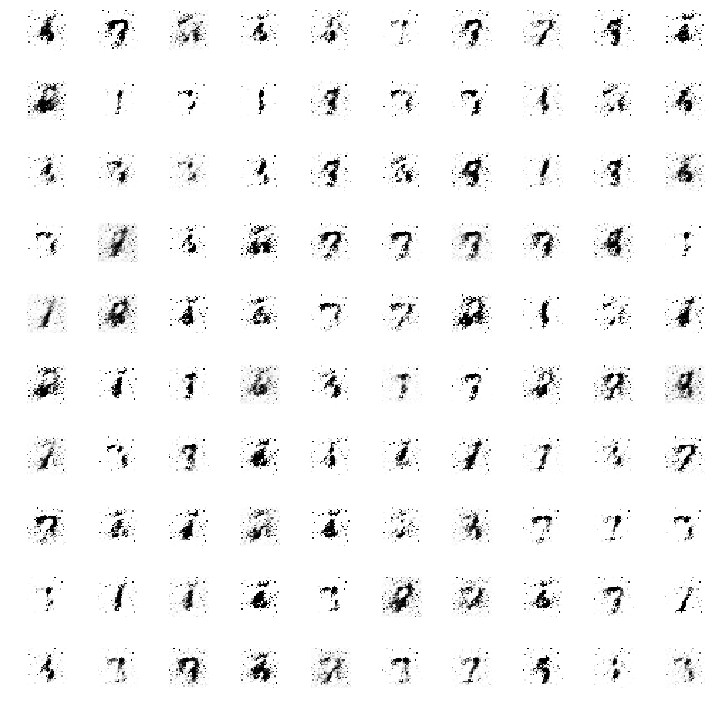

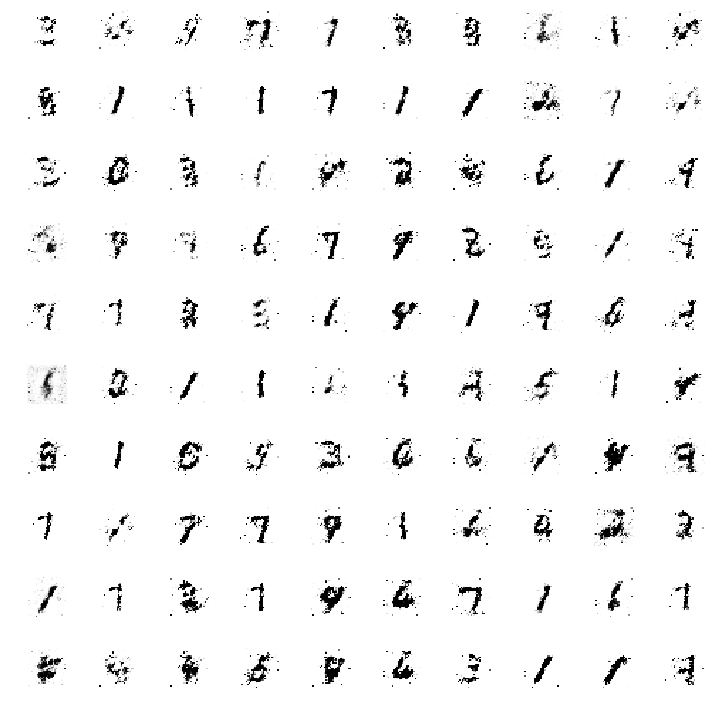

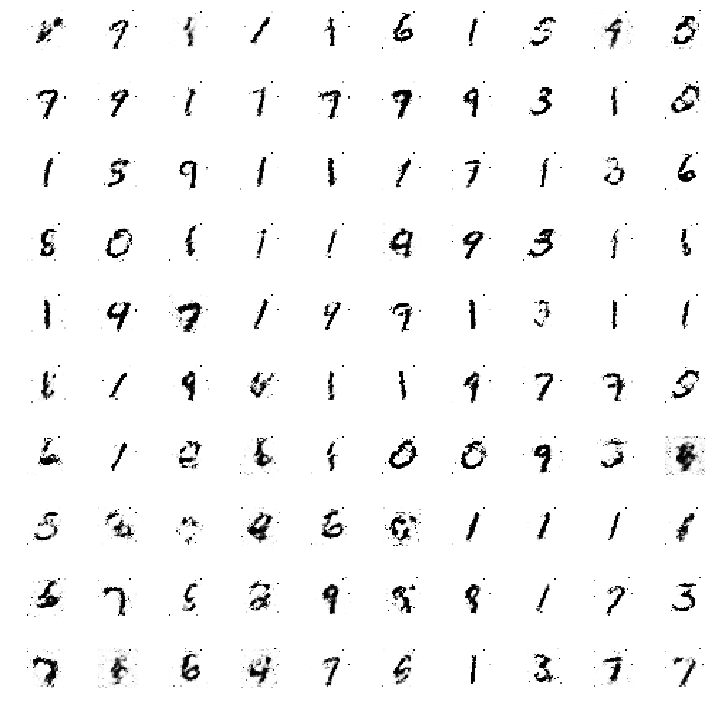

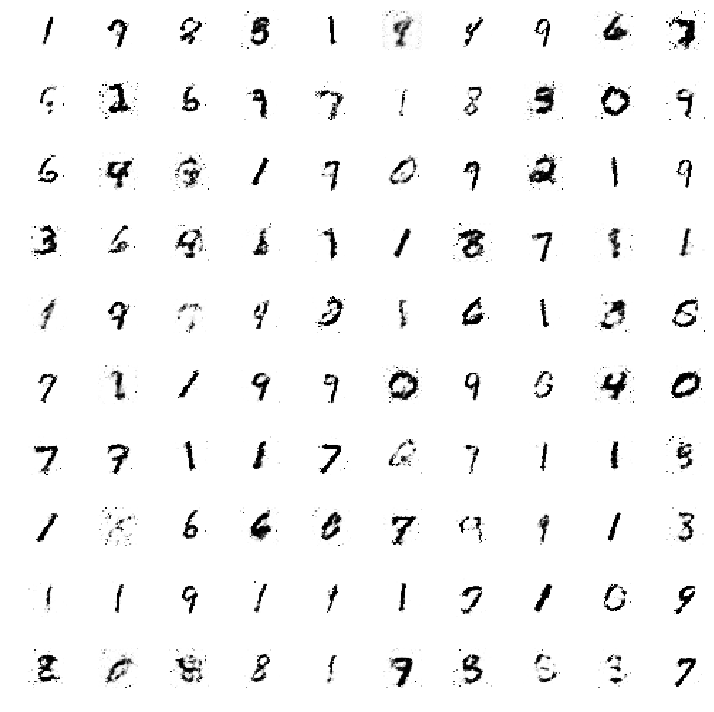

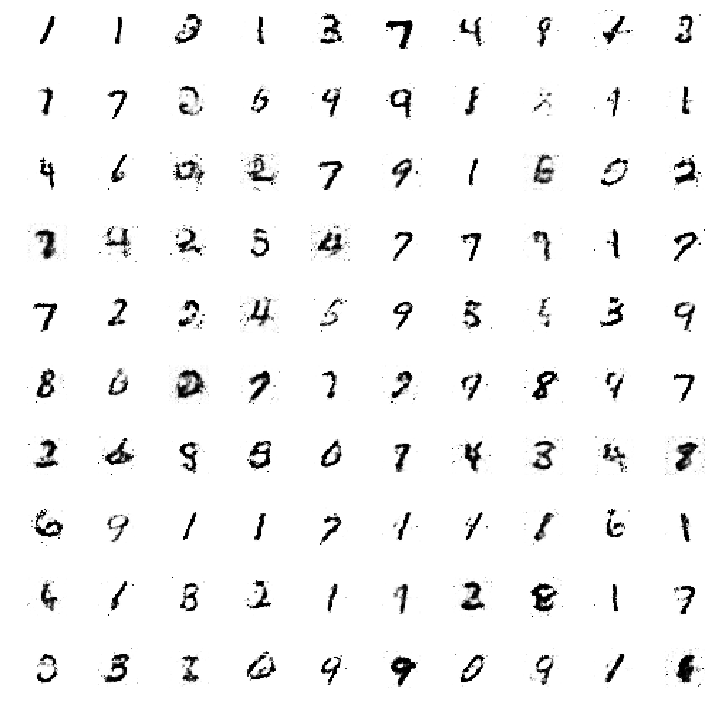

In [23]:
# Train the network
train(20, 64)